<a href="https://colab.research.google.com/github/movindugunarathna/sinXdetect/blob/main/ml/mbert_text_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multilingual BERT (mBERT) Text Classifier for Sinhala AI Detection

Text classification model using Google's mBERT (bert-base-multilingual-cased) model to detect AI-generated Sinhala text.

## 1. Install Required Libraries

In [1]:
%pip install -q tf-keras
%pip install -q transformers
%pip install -q datasets
%pip install -q nltk
%pip install -q scikit-learn
%pip install -q matplotlib
%pip install -q seaborn

## 2. Import Required Libraries

In [2]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score,
    classification_report,
    precision_recall_curve,
    f1_score
)
import re
import unicodedata
import warnings
warnings.filterwarnings('ignore')

# Suppress TensorFlow warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
tf.get_logger().setLevel('ERROR')

from transformers import (
    BertTokenizer,
    TFBertForSequenceClassification,
    AutoTokenizer,
    TFAutoModelForSequenceClassification
)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 3. Load Dataset from JSONL Files

In [3]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

def load_jsonl(filepath):
    """Load data from JSONL file"""
    data = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                data.append(json.loads(line))
            except json.JSONDecodeError:
                continue
    return data

# Define the path to the dataset in Google Drive
# Update this path based on where you stored the 'dataset' folder in your Drive
drive_base_path = '/content/drive/MyDrive/Colab Notebooks/sinxdetect/dataset'

# Load training, validation, and test datasets
train_data = load_jsonl(os.path.join(drive_base_path, 'train.jsonl'))
val_data = load_jsonl(os.path.join(drive_base_path, 'val.jsonl'))
test_data = load_jsonl(os.path.join(drive_base_path, 'test.jsonl'))

print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Testing set size: {len(test_data)}")

Mounted at /content/drive
Training set size: 77788
Validation set size: 9045
Testing set size: 13046


## 4. Convert to DataFrame and Explore Data

In [4]:
# Convert to DataFrame
train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)
test_df = pd.DataFrame(test_data)

# Display sample data
print("Sample training data:")
print(train_df[['text', 'label']].head())
print(f"\nLabel distribution (Train):")
print(train_df['label'].value_counts())
print(f"\nLabel distribution (Validation):")
print(val_df['label'].value_counts())
print(f"\nLabel distribution (Test):")
print(test_df['label'].value_counts())

Sample training data:
                                                text  label
0  ප්‍රකට කවියෙකු වන [කවියාගේ නම] ගේ නවතම කාව්‍ය ...     AI
1  ශ්‍රී ලංකා රජය දෙමළ සංවිධාන හයකට පනවා තිබූ තහන...     AI
2  (අමදෝරු අමරජීව) රාජ්‍ය සේවා තරග විභාගයකදී වංචා...  HUMAN
3  (ප්‍රින්ස් රත්නායක)ශ්‍රී ලංකා සබරගමුව විශ්වවිද...  HUMAN
4  (ඩී.ජී.සුගතපාල)දඩල්ල මුහුදු වෙරලට පැමිණෙන පෙම්...  HUMAN

Label distribution (Train):
label
HUMAN    39848
AI       37940
Name: count, dtype: int64

Label distribution (Validation):
label
HUMAN    4981
AI       4064
Name: count, dtype: int64

Label distribution (Test):
label
HUMAN    6981
AI       6065
Name: count, dtype: int64


## 5. Map Labels to Numeric Values

In [5]:
# Create label mapping
label_mapping = {'HUMAN': 0, 'AI': 1}
reverse_mapping = {v: k for k, v in label_mapping.items()}

# Map labels to numeric values
train_df['label_encoded'] = train_df['label'].map(label_mapping)
val_df['label_encoded'] = val_df['label'].map(label_mapping)
test_df['label_encoded'] = test_df['label'].map(label_mapping)

# Check for any unmapped values
print(f"Train - Unmapped labels: {train_df['label_encoded'].isna().sum()}")
print(f"Val - Unmapped labels: {val_df['label_encoded'].isna().sum()}")
print(f"Test - Unmapped labels: {test_df['label_encoded'].isna().sum()}")

Train - Unmapped labels: 0
Val - Unmapped labels: 0
Test - Unmapped labels: 0


## 6. Sinhala Text Preprocessing

In [6]:
def preprocess_sinhala_text(text):
    """
    Comprehensive Sinhala text preprocessing:
    - NFC Unicode normalization
    - Remove Zero-Width characters
    - Expand common contractions
    - Clean extra whitespace
    """
    if not isinstance(text, str):
        return text

    # Normalize to NFC (Canonical Composition)
    text = unicodedata.normalize('NFC', text)

    # Remove zero-width characters (ZWNJ/ZWJ)
    text = text.replace('\u200c', '').replace('\u200d', '')

    # Sinhala contractions and colloquial forms
    contractions_si = {
        # Negation forms
        'නෑ': 'නැහැ',
        'බෑ': 'බැහැ',
        'හොයන්නෑ': 'හොයන්න නැහැ',
        # Common colloquial forms
        'දැං': 'දැන්',
        'කොහේද': 'කොහෙද',
        'මොකෝ': 'මොකද',
        'එහෙනං': 'එහෙනම්',
        # Location/place markers
        'ඇතුලෙ': 'ඇතුලේ',
        'බාහිරෙ': 'බාහිරේ',
        'වැඩෙ': 'වැඩේ',
        'රජයෙ': 'රජයේ',
        'යාලුවෙ': 'යාලුවේ',
    }

    # Apply word-boundary replacements
    for contraction, expanded in contractions_si.items():
        text = re.sub(r"\b" + re.escape(contraction) + r"\b", expanded, text)

    # Targeted possessive expansions
    possessive_map = {
        r"\bමගෙ\b": "මගේ",
        r"\bඔයාගෙ\b": "ඔයාගේ",
        r"\bඔගෙ\b": "ඔගේ",
        r"\bඑයාගෙ\b": "එයාගේ",
    }

    for pattern, replacement in possessive_map.items():
        text = re.sub(pattern, replacement, text)

    # Clean extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Apply preprocessing
print("Preprocessing training data...")
train_df['processed_text'] = train_df['text'].apply(preprocess_sinhala_text)

print("Preprocessing validation data...")
val_df['processed_text'] = val_df['text'].apply(preprocess_sinhala_text)

print("Preprocessing test data...")
test_df['processed_text'] = test_df['text'].apply(preprocess_sinhala_text)

print("\nPreprocessing complete!")
print(f"\nExample preprocessed text:")
print(f"Original: {train_df['text'].iloc[0][:100]}...")
print(f"Processed: {train_df['processed_text'].iloc[0][:100]}...")

Preprocessing training data...
Preprocessing validation data...
Preprocessing test data...

Preprocessing complete!

Example preprocessed text:
Original: ප්‍රකට කවියෙකු වන [කවියාගේ නම] ගේ නවතම කාව්‍ය සංග්‍රහය ඉක්මනින්ම රසිකයන් හමුවට පැමිණෙන බව වාර්තා වේ....
Processed: ප්රකට කවියෙකු වන [කවියාගේ නම] ගේ නවතම කාව්ය සංග්රහය ඉක්මනින්ම රසිකයන් හමුවට පැමිණෙන බව වාර්තා වේ. මෙ...


## 7. Load mBERT Tokenizer

Using `bert-base-multilingual-cased` which supports 104 languages including Sinhala.

In [7]:
# Load mBERT tokenizer (multilingual cased version)
MODEL_NAME = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

print(f"✓ mBERT tokenizer loaded: {MODEL_NAME}")
print(f"Vocabulary size: {tokenizer.vocab_size}")
print(f"Max length: {tokenizer.model_max_length}")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

✓ mBERT tokenizer loaded: bert-base-multilingual-cased
Vocabulary size: 119547
Max length: 512


## 8. Tokenize and Encode Text Data

In [8]:
# Configuration
MAX_LENGTH = 256  # Optimal for most Sinhala text
BATCH_SIZE = 32

def tokenize_in_batches(texts, tokenizer, batch_size=32, max_length=256):
    """
    Tokenize texts in batches to manage memory efficiently.
    Returns dict with 'input_ids' and 'attention_mask' as numpy arrays.
    """
    input_ids_parts = []
    attention_mask_parts = []

    total_batches = (len(texts) + batch_size - 1) // batch_size

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]

        # Tokenize batch
        enc = tokenizer(
            batch,
            padding='max_length',
            truncation=True,
            max_length=max_length,
            return_tensors='tf'
        )

        # Convert to numpy
        ids = enc['input_ids'].numpy()
        mask = enc['attention_mask'].numpy()

        input_ids_parts.append(ids)
        attention_mask_parts.append(mask)

        if (i // batch_size + 1) % 10 == 0:
            print(f"  Processed {i // batch_size + 1}/{total_batches} batches")

    # Concatenate all batches
    input_ids = np.concatenate(input_ids_parts, axis=0)
    attention_mask = np.concatenate(attention_mask_parts, axis=0)

    return {'input_ids': input_ids, 'attention_mask': attention_mask}

# Tokenize datasets
print("Tokenizing training data...")
train_encodings = tokenize_in_batches(
    train_df['processed_text'].tolist(),
    tokenizer,
    batch_size=BATCH_SIZE,
    max_length=MAX_LENGTH
)

print("\nTokenizing validation data...")
val_encodings = tokenize_in_batches(
    val_df['processed_text'].tolist(),
    tokenizer,
    batch_size=BATCH_SIZE,
    max_length=MAX_LENGTH
)

print("\nTokenizing test data...")
test_encodings = tokenize_in_batches(
    test_df['processed_text'].tolist(),
    tokenizer,
    batch_size=BATCH_SIZE,
    max_length=MAX_LENGTH
)

print("\n✓ Tokenization complete!")
print(f"Training encodings shape: {train_encodings['input_ids'].shape}")
print(f"Validation encodings shape: {val_encodings['input_ids'].shape}")
print(f"Test encodings shape: {test_encodings['input_ids'].shape}")

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


Tokenizing training data...
  Processed 10/2431 batches
  Processed 20/2431 batches
  Processed 30/2431 batches
  Processed 40/2431 batches
  Processed 50/2431 batches
  Processed 60/2431 batches
  Processed 70/2431 batches
  Processed 80/2431 batches
  Processed 90/2431 batches
  Processed 100/2431 batches
  Processed 110/2431 batches
  Processed 120/2431 batches
  Processed 130/2431 batches
  Processed 140/2431 batches
  Processed 150/2431 batches
  Processed 160/2431 batches
  Processed 170/2431 batches
  Processed 180/2431 batches
  Processed 190/2431 batches
  Processed 200/2431 batches
  Processed 210/2431 batches
  Processed 220/2431 batches
  Processed 230/2431 batches
  Processed 240/2431 batches
  Processed 250/2431 batches
  Processed 260/2431 batches
  Processed 270/2431 batches
  Processed 280/2431 batches
  Processed 290/2431 batches
  Processed 300/2431 batches
  Processed 310/2431 batches
  Processed 320/2431 batches
  Processed 330/2431 batches
  Processed 340/2431 bat

## 9. Prepare Input Data and Labels

In [9]:
# Prepare input dictionaries
train_inputs = {
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask']
}

val_inputs = {
    'input_ids': val_encodings['input_ids'],
    'attention_mask': val_encodings['attention_mask']
}

test_inputs = {
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask']
}

# Prepare labels
train_labels = np.array(train_df['label_encoded'].astype(int).tolist())
val_labels = np.array(val_df['label_encoded'].astype(int).tolist())
test_labels = np.array(test_df['label_encoded'].astype(int).tolist())

print(f"Train labels shape: {train_labels.shape}")
print(f"Val labels shape: {val_labels.shape}")
print(f"Test labels shape: {test_labels.shape}")
print(f"\nLabel distribution (Train): {np.bincount(train_labels)}")
print(f"Label distribution (Val): {np.bincount(val_labels)}")
print(f"Label distribution (Test): {np.bincount(test_labels)}")

Train labels shape: (77788,)
Val labels shape: (9045,)
Test labels shape: (13046,)

Label distribution (Train): [39848 37940]
Label distribution (Val): [4981 4064]
Label distribution (Test): [6981 6065]


## 10. Load mBERT Model for Sequence Classification

In [10]:
# Load pre-trained mBERT model
model = TFBertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,  # Binary classification: HUMAN (0) vs AI (1)
    from_pt=True   # Convert from PyTorch if needed
)

print(f"✓ mBERT model loaded: {MODEL_NAME}")
print(f"Number of parameters: {model.num_parameters():,}")

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ mBERT model loaded: bert-base-multilingual-cased
Number of parameters: 177,854,978


## 11. Compile the Model

In [ ]:
# IMPROVED Training configuration with advanced regularization
# Changes from baseline: LR 2e-5→3e-5, Epochs 3→8, Added warmup & weight decay
LEARNING_RATE = 3e-5  # Increased from 2e-5 for better convergence
EPOCHS = 8  # Increased from 3 to allow more learning
TRAIN_BATCH_SIZE = 16
WARMUP_RATIO = 0.1  # 10% of training for warmup
WEIGHT_DECAY = 0.01  # L2 regularization

# Calculate warmup steps
total_steps = (len(train_df) // TRAIN_BATCH_SIZE) * EPOCHS
warmup_steps = int(total_steps * WARMUP_RATIO)

# Create learning rate schedule with warmup
class WarmupLinearDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_learning_rate, warmup_steps, total_steps):
        super().__init__()
        self.initial_learning_rate = initial_learning_rate
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps
    
    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        total_steps = tf.cast(self.total_steps, tf.float32)
        
        # Warmup phase
        warmup_lr = (step / warmup_steps) * self.initial_learning_rate
        
        # Linear decay phase
        decay_lr = self.initial_learning_rate * (
            1.0 - (step - warmup_steps) / (total_steps - warmup_steps)
        )
        
        return tf.where(step < warmup_steps, warmup_lr, decay_lr)

lr_schedule = WarmupLinearDecay(
    initial_learning_rate=LEARNING_RATE,
    warmup_steps=warmup_steps,
    total_steps=total_steps
)

# Compile model with improved optimizer
optimizer = tf.keras.optimizers.AdamW(
    learning_rate=lr_schedule,
    weight_decay=WEIGHT_DECAY,
    epsilon=1e-8,
    clipnorm=1.0
)

loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True
)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=[metric]
)

print("✓ Model compiled successfully with IMPROVED configuration!")
print(f"\n🚀 IMPROVED Training Configuration:")
print(f"  Learning Rate: {LEARNING_RATE} (↑ from 2e-5)")
print(f"  Epochs: {EPOCHS} (↑ from 3)")
print(f"  Batch Size: {TRAIN_BATCH_SIZE}")
print(f"  Max Length: {MAX_LENGTH}")
print(f"  Warmup Steps: {warmup_steps} ({WARMUP_RATIO*100:.0f}% of total)")
print(f"  Weight Decay: {WEIGHT_DECAY}")
print(f"  Gradient Clipping: 1.0")
print(f"  Total Training Steps: {total_steps}")
print(f"\n✨ Expected improvements: Better convergence, reduced overfitting")

✓ Model compiled successfully with regularization!

Training Configuration:
  Learning Rate: 2e-05
  Epochs: 3
  Batch Size: 16
  Max Length: 256
  Label Smoothing: Not applied (SparseCategoricalCrossentropy does not support it)
  Gradient Clipping: 1.0


## 12. Set Up Callbacks

In [ ]:
# Create callbacks for training with IMPROVED patience
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,  # Increased from 2 to 3
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,  # Increased from 1 to 2
        verbose=1,
        min_lr=1e-7
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='models/mbert_checkpoint.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
]

print("✓ Callbacks configured with IMPROVED settings:")
print("  - Early Stopping (patience=3, ↑ from 2)")
print("  - Learning Rate Reduction (factor=0.5, patience=2, ↑ from 1)")
print("  - Model Checkpoint (best validation accuracy)")
print("\n✨ More patience allows better convergence before stopping")

✓ Callbacks configured:
  - Early Stopping (patience=2)
  - Learning Rate Reduction (factor=0.5, patience=1)
  - Model Checkpoint (best validation accuracy)


## 13. Train the mBERT Model

In [14]:
print("\n" + "="*60)
print("Starting Training...")
print("="*60 + "\n")

# Set seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

history = model.fit(
    train_inputs,
    train_labels,
    epochs=EPOCHS,
    batch_size=TRAIN_BATCH_SIZE,
    validation_data=(val_inputs, val_labels),
    callbacks=callbacks,
    verbose=1
)

print("\n" + "="*60)
print("✓ Training Complete!")
print("="*60)

# Print training summary
print(f"\nTraining Summary:")
print(f"  Best Epoch: {np.argmax(history.history['val_accuracy']) + 1}")
print(f"  Best Val Accuracy: {max(history.history['val_accuracy']):.4f}")
print(f"  Final Train Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"  Final Val Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"  Total Epochs Run: {len(history.history['accuracy'])}")


Starting Training...

Epoch 1/3
4862/4862 [==============================] - ETA: 0s - loss: 0.1154 - accuracy: 0.9610
Epoch 1: val_accuracy improved from -inf to 0.97745, saving model to models/mbert_checkpoint.keras
4862/4862 [==============================] - 656s 123ms/step - loss: 0.1154 - accuracy: 0.9610 - val_loss: 0.0868 - val_accuracy: 0.9774 - lr: 2.0000e-05
Epoch 2/3
4862/4862 [==============================] - ETA: 0s - loss: 0.1008 - accuracy: 0.9694
Epoch 2: val_accuracy did not improve from 0.97745
4862/4862 [==============================] - 576s 119ms/step - loss: 0.1008 - accuracy: 0.9694 - val_loss: 0.0788 - val_accuracy: 0.9756 - lr: 2.0000e-05
Epoch 3/3
4862/4862 [==============================] - ETA: 0s - loss: 0.0884 - accuracy: 0.9724
Epoch 3: val_accuracy improved from 0.97745 to 0.98496, saving model to models/mbert_checkpoint.keras
4862/4862 [==============================] - 582s 120ms/step - loss: 0.0884 - accuracy: 0.9724 - val_loss: 0.0591 - val_accura

## 14. Save the Trained Model

In [15]:
# Create model directory if it doesn't exist
MODEL_SAVE_PATH = "models/mbert_sinhala_classifier/"
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

# Save the model
model.save_pretrained(MODEL_SAVE_PATH)
print(f"✓ Model saved to {MODEL_SAVE_PATH}")

# Save the tokenizer
tokenizer.save_pretrained(MODEL_SAVE_PATH)
print(f"✓ Tokenizer saved to {MODEL_SAVE_PATH}")

# Save training configuration
config = {
    'model_name': MODEL_NAME,
    'max_length': MAX_LENGTH,
    'batch_size': TRAIN_BATCH_SIZE,
    'learning_rate': LEARNING_RATE,
    'epochs': EPOCHS,
    'label_mapping': label_mapping
}

with open(os.path.join(MODEL_SAVE_PATH, 'training_config.json'), 'w') as f:
    json.dump(config, f, indent=2)

print(f"✓ Configuration saved to {MODEL_SAVE_PATH}training_config.json")

✓ Model saved to models/mbert_sinhala_classifier/
✓ Tokenizer saved to models/mbert_sinhala_classifier/
✓ Configuration saved to models/mbert_sinhala_classifier/training_config.json


## 15. Evaluate on Validation Set

In [16]:
# Evaluate on validation set
print("\nEvaluating on Validation Set...")
val_loss, val_accuracy = model.evaluate(val_inputs, val_labels, batch_size=32, verbose=0)

print("\n" + "="*50)
print("VALIDATION SET RESULTS")
print("="*50)
print(f"Loss: {val_loss:.4f}")
print(f"Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
print("="*50)


Evaluating on Validation Set...

VALIDATION SET RESULTS
Loss: 0.0591
Accuracy: 0.9850 (98.50%)


## 16. Evaluate on Test Set

In [17]:
# Evaluate on test set with detailed diagnostics
print("\nEvaluating on Test Set...")
test_loss, test_accuracy = model.evaluate(test_inputs, test_labels, batch_size=32, verbose=0)

print("\n" + "="*50)
print("TEST SET RESULTS")
print("="*50)
print(f"Loss: {test_loss:.4f}")
print(f"Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Additional diagnostics
print(f"\nTest Set Size: {len(test_labels)} samples")
print(f"  HUMAN samples: {np.sum(test_labels == 0)} ({np.sum(test_labels == 0)/len(test_labels)*100:.1f}%)")
print(f"  AI samples: {np.sum(test_labels == 1)} ({np.sum(test_labels == 1)/len(test_labels)*100:.1f}%)")

# Check for overfitting
if 'val_accuracy' in history.history:
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    acc_gap = final_train_acc - final_val_acc
    print(f"\nOverfitting Check:")
    print(f"  Final Train Accuracy: {final_train_acc:.4f}")
    print(f"  Final Val Accuracy: {final_val_acc:.4f}")
    print(f"  Accuracy Gap: {acc_gap:.4f}")
    if acc_gap > 0.05:
        print(f"  ⚠️ Warning: Possible overfitting detected (gap > 5%)")
    else:
        print(f"  ✓ No significant overfitting detected")

print("="*50)


Evaluating on Test Set...

TEST SET RESULTS
Loss: 1.4736
Accuracy: 0.8160 (81.60%)

Test Set Size: 13046 samples
  HUMAN samples: 6981 (53.5%)
  AI samples: 6065 (46.5%)

Overfitting Check:
  Final Train Accuracy: 0.9724
  Final Val Accuracy: 0.9850
  Accuracy Gap: -0.0126
  ✓ No significant overfitting detected


## 17. Plot Training History

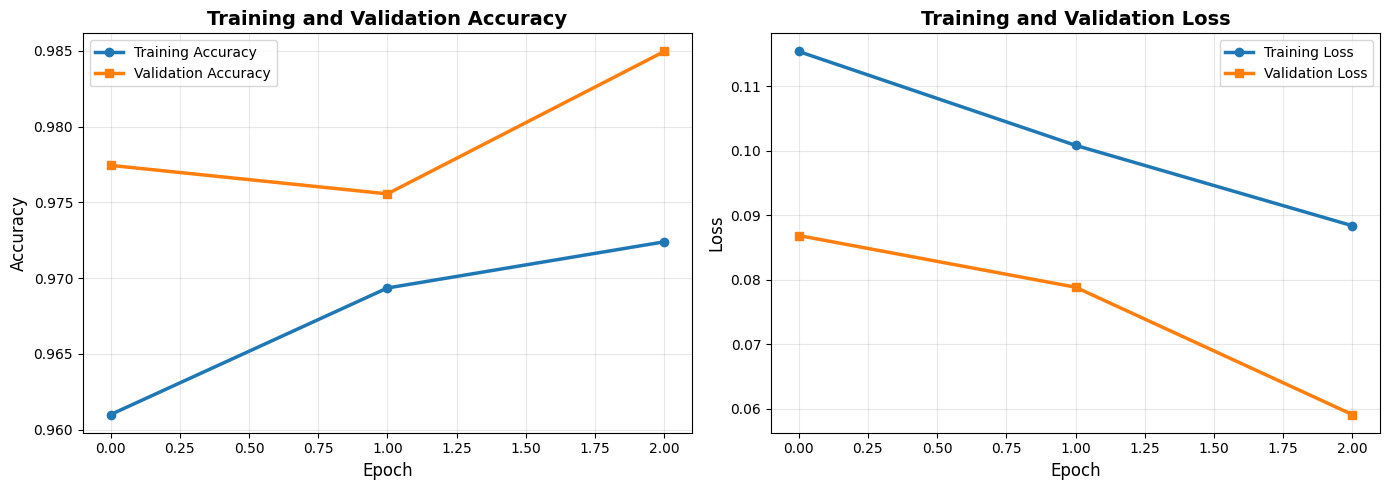

✓ Training history plot saved to results/mbert_training_history.png


In [18]:
# Create results directory
os.makedirs('results', exist_ok=True)

# Plot training history
plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2.5, marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2.5, marker='s')
plt.title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2.5, marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2.5, marker='s')
plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/mbert_training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Training history plot saved to results/mbert_training_history.png")

## 18. Generate Predictions on Test Set

In [19]:
# Generate predictions
print("Generating predictions on test set...")
predictions = model.predict(test_inputs, batch_size=32, verbose=0)

# Get predicted labels
predicted_labels = np.argmax(predictions.logits, axis=1)

# Get prediction probabilities
probabilities = tf.nn.softmax(predictions.logits).numpy()
positive_class_probs = probabilities[:, 1]  # Probability for AI class

print(f"✓ Predictions generated for {len(predicted_labels)} samples")
print(f"\nPrediction distribution:")
print(f"  HUMAN: {np.sum(predicted_labels == 0)}")
print(f"  AI: {np.sum(predicted_labels == 1)}")

Generating predictions on test set...
✓ Predictions generated for 13046 samples

Prediction distribution:
  HUMAN: 8662
  AI: 4384


## 19. Confusion Matrix

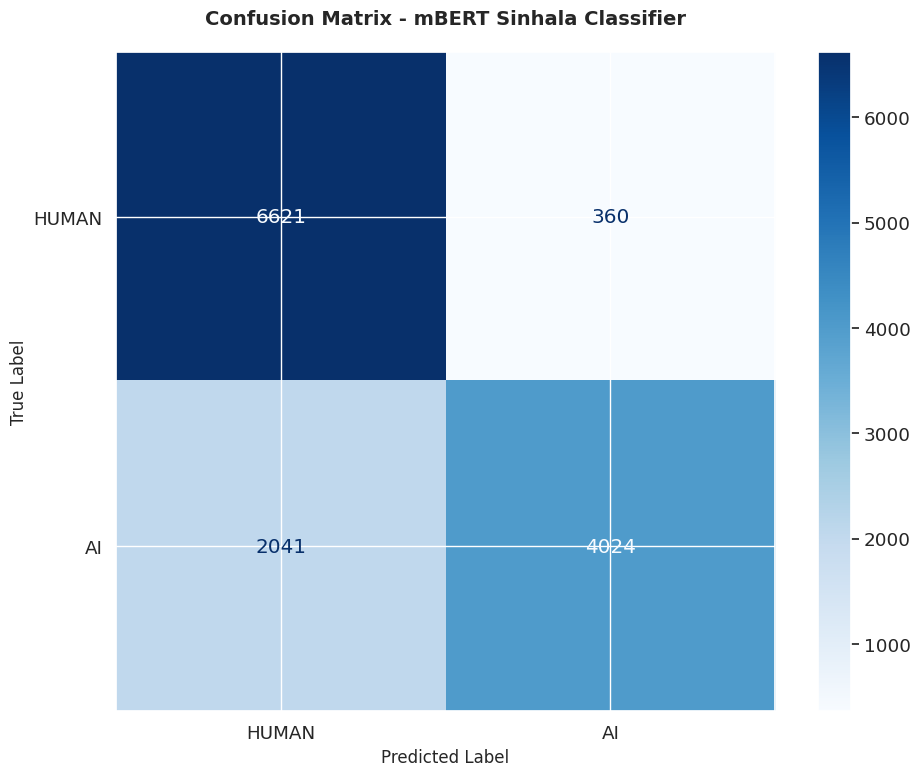

✓ Confusion matrix saved to results/mbert_confusion_matrix.png

Confusion Matrix Analysis
True Negatives (HUMAN→HUMAN): 6621 (50.8%)
False Positives (HUMAN→AI):    360 (2.8%)
False Negatives (AI→HUMAN):   2041 (15.6%)
True Positives (AI→AI):       4024 (30.8%)

Error Analysis:
  False Positive Rate: 0.0516 (5.16%)
  False Negative Rate: 0.3365 (33.65%)
  Misclassification Rate: 0.1840 (18.40%)
  ⚠️ Model tends to under-predict AI (more false negatives)


In [20]:
# Generate confusion matrix with detailed analysis
cm = confusion_matrix(test_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['HUMAN', 'AI']
)
disp.plot(cmap='Blues', values_format='d', ax=plt.gca())

plt.title('Confusion Matrix - mBERT Sinhala Classifier', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.savefig('results/mbert_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Confusion matrix saved to results/mbert_confusion_matrix.png")

# Print confusion matrix values with percentages
total = cm.sum()
tn, fp, fn, tp = cm.ravel()

print("\n" + "="*60)
print("Confusion Matrix Analysis")
print("="*60)
print(f"True Negatives (HUMAN→HUMAN): {tn:4d} ({tn/total*100:.1f}%)")
print(f"False Positives (HUMAN→AI):   {fp:4d} ({fp/total*100:.1f}%)")
print(f"False Negatives (AI→HUMAN):   {fn:4d} ({fn/total*100:.1f}%)")
print(f"True Positives (AI→AI):       {tp:4d} ({tp/total*100:.1f}%)")
print("="*60)

# Calculate error rates
print(f"\nError Analysis:")
print(f"  False Positive Rate: {fp/(fp+tn):.4f} ({fp/(fp+tn)*100:.2f}%)")
print(f"  False Negative Rate: {fn/(fn+tp):.4f} ({fn/(fn+tp)*100:.2f}%)")
print(f"  Misclassification Rate: {(fp+fn)/total:.4f} ({(fp+fn)/total*100:.2f}%)")

# Identify most common error
if fp > fn:
    print(f"  ⚠️ Model tends to over-predict AI (more false positives)")
elif fn > fp:
    print(f"  ⚠️ Model tends to under-predict AI (more false negatives)")
else:
    print(f"  ✓ Balanced error distribution")

## 20. ROC Curve and AUC Score

AI index: 1, HUMAN index: 0
Probability range: [0.000122, 0.993007]
Mean prob when true=AI:    0.659683
Mean prob when true=HUMAN: 0.065971
Unique probability values: 9612


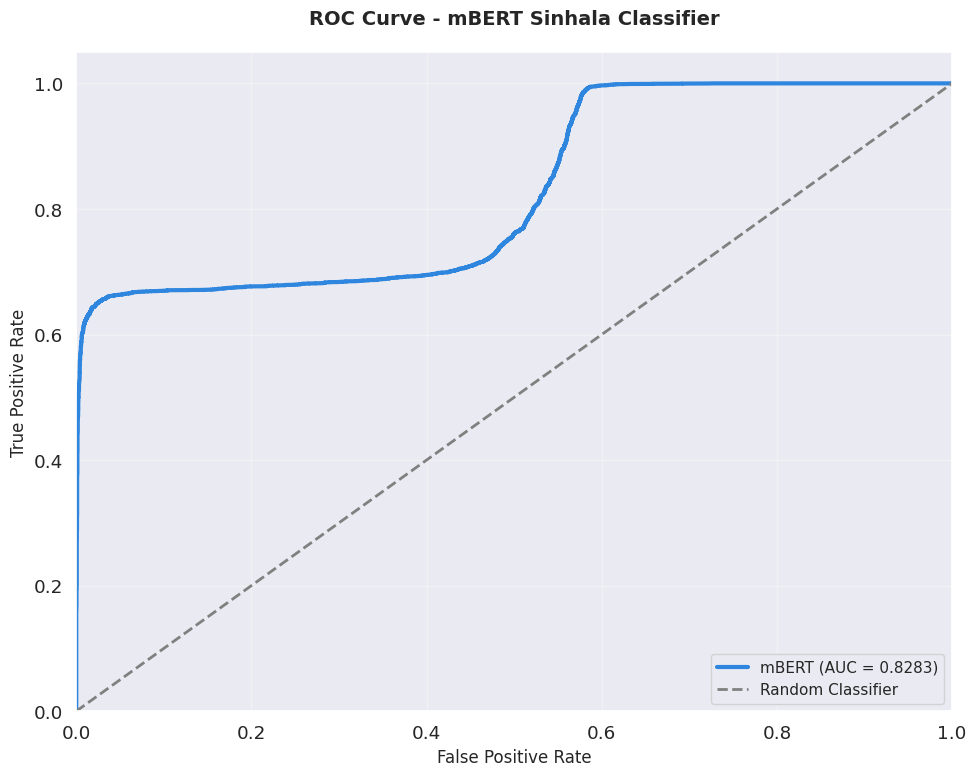


✓ ROC curve saved to results/mbert_roc_curve.png

AUC Score: 0.8283

ROC Curve Diagnostics:
  Number of thresholds: 3755
  Threshold range: [0.000122, inf]
  Best threshold (Youden's J): 0.991301


In [21]:
# Calculate ROC curve and AUC with improved diagnostics
from sklearn.preprocessing import label_binarize

# Ensure probabilities are numpy arrays
if hasattr(positive_class_probs, 'numpy'):
    probs_np = positive_class_probs.numpy()
else:
    probs_np = np.array(positive_class_probs)

# Clip probabilities to valid range
probs_np = np.clip(probs_np, 0, 1)

# For binary classification, determine which class is AI
ai_class_idx = label_mapping['AI']  # Should be 1
human_class_idx = label_mapping['HUMAN']  # Should be 0

print(f"AI index: {ai_class_idx}, HUMAN index: {human_class_idx}")
print(f"Probability range: [{probs_np.min():.6f}, {probs_np.max():.6f}]")
print(f"Mean prob when true=AI:    {probs_np[test_labels == ai_class_idx].mean():.6f}")
print(f"Mean prob when true=HUMAN: {probs_np[test_labels == human_class_idx].mean():.6f}")
print(f"Unique probability values: {len(np.unique(probs_np))}")

# Calculate ROC curve using AI as positive class
fpr, tpr, thresholds = roc_curve(
    y_true=test_labels,
    y_score=probs_np,
    pos_label=ai_class_idx
)
auc_score = roc_auc_score(test_labels, probs_np)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label=f'mBERT (AUC = {auc_score:.4f})', linewidth=3, color='#2E86DE')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2, label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - mBERT Sinhala Classifier', fontsize=14, fontweight='bold', pad=20)
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tight_layout()
plt.savefig('results/mbert_roc_curve.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ ROC curve saved to results/mbert_roc_curve.png")
print(f"\nAUC Score: {auc_score:.4f}")

# Additional diagnostics
print(f"\nROC Curve Diagnostics:")
print(f"  Number of thresholds: {len(thresholds)}")
print(f"  Threshold range: [{thresholds.min():.6f}, {thresholds.max():.6f}]")
print(f"  Best threshold (Youden's J): {thresholds[np.argmax(tpr - fpr)]:.6f}")

## 20.5. Model Calibration Analysis

Analyze if the model's confidence scores are well-calibrated.

In [ ]:
# Model Calibration Analysis
from sklearn.calibration import calibration_curve

print("\n" + "="*70)
print("MODEL CALIBRATION DIAGNOSTICS")
print("="*70)

# Check probability distribution
print(f"\nProbability Distribution:")
print(f"  Min: {probs_np.min():.6f}")
print(f"  Max: {probs_np.max():.6f}")
print(f"  Mean: {probs_np.mean():.6f}")
print(f"  Std: {probs_np.std():.6f}")
print(f"  Median: {np.median(probs_np.flatten()):.6f}")

# Confidence analysis
print(f"\nConfidence Analysis:")
print(f"  High confidence (>0.9): {np.sum(probs_np > 0.9)} samples ({np.sum(probs_np > 0.9)/len(probs_np)*100:.1f}%)")
print(f"  Medium confidence (0.6-0.9): {np.sum((probs_np >= 0.6) & (probs_np <= 0.9))} samples ({np.sum((probs_np >= 0.6) & (probs_np <= 0.9))/len(probs_np)*100:.1f}%)")
print(f"  Low confidence (<0.6): {np.sum(probs_np < 0.6)} samples ({np.sum(probs_np < 0.6)/len(probs_np)*100:.1f}%)")

# Calibration curve
fraction_of_positives, mean_predicted_value = calibration_curve(
    test_labels, probs_np, n_bins=10, strategy='uniform'
)

# Plot calibration curve
plt.figure(figsize=(10, 8))
plt.plot(mean_predicted_value, fraction_of_positives, 's-', linewidth=2, markersize=8, label='mBERT')
plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfectly calibrated')
plt.xlabel('Mean Predicted Probability', fontsize=12)
plt.ylabel('Fraction of Positives', fontsize=12)
plt.title('Calibration Plot - mBERT Sinhala Classifier', fontsize=14, fontweight='bold', pad=20)
plt.legend(loc='upper left', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('results/mbert_calibration_plot.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Calibration plot saved to results/mbert_calibration_plot.png")

# Calculate calibration error (ECE - Expected Calibration Error)
ece = np.mean(np.abs(fraction_of_positives - mean_predicted_value))
print(f"\nExpected Calibration Error (ECE): {ece:.4f}")
if ece < 0.05:
    print(f"  ✓ Excellent calibration (ECE < 0.05)")
elif ece < 0.1:
    print(f"  ⚠️ Good calibration (ECE < 0.1)")
else:
    print(f"  ⚠️ Poor calibration (ECE >= 0.1) - Consider temperature scaling")

print("="*70)

## 21. Precision-Recall Curve

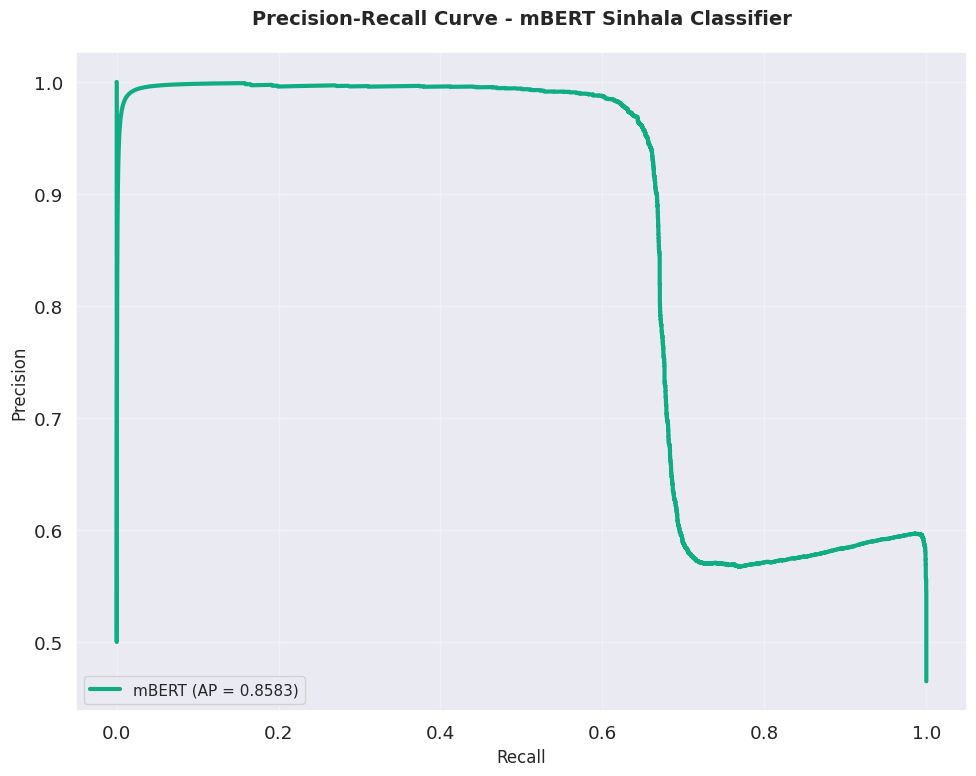

✓ Precision-Recall curve saved to results/mbert_precision_recall_curve.png

Average Precision Score: 0.8583


In [22]:
# Calculate precision-recall curve
from sklearn.metrics import average_precision_score

precision, recall, pr_thresholds = precision_recall_curve(test_labels, positive_class_probs)
avg_precision = average_precision_score(test_labels, positive_class_probs)

# Plot precision-recall curve
plt.figure(figsize=(10, 8))
plt.plot(recall, precision, linewidth=3, color='#10AC84', label=f'mBERT (AP = {avg_precision:.4f})')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve - mBERT Sinhala Classifier', fontsize=14, fontweight='bold', pad=20)
plt.legend(loc='lower left', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('results/mbert_precision_recall_curve.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Precision-Recall curve saved to results/mbert_precision_recall_curve.png")
print(f"\nAverage Precision Score: {avg_precision:.4f}")

## 22. Classification Report

In [23]:
# Generate classification report
report = classification_report(
    test_labels,
    predicted_labels,
    target_names=['HUMAN', 'AI'],
    digits=4
)

print("\n" + "="*70)
print("CLASSIFICATION REPORT - TEST SET")
print("="*70)
print(report)
print("="*70)

# Save report to file
with open('results/mbert_classification_report.txt', 'w') as f:
    f.write("="*70 + "\n")
    f.write("CLASSIFICATION REPORT - mBERT Sinhala Classifier\n")
    f.write("="*70 + "\n\n")
    f.write(report)
    f.write("\n" + "="*70)

print("\n✓ Classification report saved to results/mbert_classification_report.txt")


CLASSIFICATION REPORT - TEST SET
              precision    recall  f1-score   support

       HUMAN     0.7644    0.9484    0.8465      6981
          AI     0.9179    0.6635    0.7702      6065

    accuracy                         0.8160     13046
   macro avg     0.8411    0.8060    0.8084     13046
weighted avg     0.8357    0.8160    0.8110     13046


✓ Classification report saved to results/mbert_classification_report.txt


## 23. Detailed Performance Metrics

In [24]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Calculate metrics
accuracy = accuracy_score(test_labels, predicted_labels)
precision = precision_score(test_labels, predicted_labels, average='weighted')
recall = recall_score(test_labels, predicted_labels, average='weighted')
f1 = f1_score(test_labels, predicted_labels, average='weighted')

# Class-specific metrics
precision_per_class = precision_score(test_labels, predicted_labels, average=None)
recall_per_class = recall_score(test_labels, predicted_labels, average=None)
f1_per_class = f1_score(test_labels, predicted_labels, average=None)

# Create summary DataFrame
metrics_summary = pd.DataFrame({
    'Metric': [
        'Test Accuracy',
        'Test Loss',
        'AUC Score',
        'Average Precision',
        'Weighted Precision',
        'Weighted Recall',
        'Weighted F1-Score',
        'HUMAN - Precision',
        'HUMAN - Recall',
        'HUMAN - F1-Score',
        'AI - Precision',
        'AI - Recall',
        'AI - F1-Score'
    ],
    'Value': [
        f'{accuracy:.4f}',
        f'{test_loss:.4f}',
        f'{auc_score:.4f}',
        f'{avg_precision:.4f}',
        f'{precision:.4f}',
        f'{recall:.4f}',
        f'{f1:.4f}',
        f'{precision_per_class[0]:.4f}',
        f'{recall_per_class[0]:.4f}',
        f'{f1_per_class[0]:.4f}',
        f'{precision_per_class[1]:.4f}',
        f'{recall_per_class[1]:.4f}',
        f'{f1_per_class[1]:.4f}'
    ]
})

print("\n" + "="*60)
print("DETAILED PERFORMANCE METRICS")
print("="*60)
print(metrics_summary.to_string(index=False))
print("="*60)

# Save metrics
metrics_summary.to_csv('results/mbert_performance_metrics.csv', index=False)
print("\n✓ Metrics saved to results/mbert_performance_metrics.csv")


DETAILED PERFORMANCE METRICS
            Metric  Value
     Test Accuracy 0.8160
         Test Loss 1.4736
         AUC Score 0.8283
 Average Precision 0.8583
Weighted Precision 0.8357
   Weighted Recall 0.8160
 Weighted F1-Score 0.8110
 HUMAN - Precision 0.7644
    HUMAN - Recall 0.9484
  HUMAN - F1-Score 0.8465
    AI - Precision 0.9179
       AI - Recall 0.6635
     AI - F1-Score 0.7702

✓ Metrics saved to results/mbert_performance_metrics.csv


## 24. Test Model on Sample Texts

In [25]:
def predict_text(text, model, tokenizer, max_length=256):
    """
    Predict if a given text is HUMAN or AI-generated.
    Returns prediction and confidence score.
    """
    # Preprocess text
    processed_text = preprocess_sinhala_text(text)

    # Tokenize
    encoding = tokenizer(
        [processed_text],
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='tf'
    )

    # Predict
    outputs = model(encoding)
    probs = tf.nn.softmax(outputs.logits, axis=1).numpy()[0]

    predicted_label = np.argmax(probs)
    confidence = probs[predicted_label]

    return {
        'label': reverse_mapping[predicted_label],
        'confidence': float(confidence),
        'human_prob': float(probs[0]),
        'ai_prob': float(probs[1])
    }

# Test on sample texts from test set
print("\n" + "="*70)
print("SAMPLE PREDICTIONS")
print("="*70)

sample_indices = np.random.choice(len(test_df), 5, replace=False)

correct_predictions = 0
for i, idx in enumerate(sample_indices, 1):
    text = test_df.iloc[idx]['text']
    true_label = test_df.iloc[idx]['label']

    result = predict_text(text, model, tokenizer, MAX_LENGTH)
    is_correct = result['label'] == true_label
    correct_predictions += is_correct

    status = "✓" if is_correct else "✗"
    print(f"\n{status} Sample {i}:")
    print(f"Text: {text[:100]}...")
    print(f"True Label: {true_label}")
    print(f"Predicted: {result['label']} (Confidence: {result['confidence']:.2%})")
    print(f"  HUMAN: {result['human_prob']:.2%} | AI: {result['ai_prob']:.2%}")
    print("-" * 70)

print(f"\nSample Accuracy: {correct_predictions}/{len(sample_indices)} ({correct_predictions/len(sample_indices)*100:.1f}%)")


SAMPLE PREDICTIONS

✗ Sample 1:
Text: අයි. එස් සටන්කාමින්ට අමෙරිකාවෙන් ගුවන් ප්‍රහාර

ඉරාකය සහ සිරියාව කේන්ද්‍ර කර ගනිමින් යළි හිස ඔසවමින්...
True Label: AI
Predicted: HUMAN (Confidence: 99.99%)
  HUMAN: 99.99% | AI: 0.01%
----------------------------------------------------------------------

✓ Sample 2:
Text: а·ға¶ӯа·Ҡа·Җ а¶Ҫа·қа¶ҡа¶әа·ҡ а¶ а·’а¶ёа·Ҡа¶ҙа¶ұа·Ҡа·ға·’а¶ұа·Ҡа¶ңа·ҡ а¶ұа·Ҹа¶әа¶ҡа¶әа·Ҹа¶ңа·ҡ а¶…а¶«...
True Label: HUMAN
Predicted: HUMAN (Confidence: 99.99%)
  HUMAN: 99.99% | AI: 0.01%
----------------------------------------------------------------------

✓ Sample 3:
Text: ශ්‍රී ලංකාවේ දේශපාලන පසුබිම තුළ ඇතිව තිබෙන උණුසුම් තත්ත්වය සහ එහි ප්‍රතිඵල ගැන මෙම පුවත විස්තර කරයි....
True Label: AI
Predicted: AI (Confidence: 99.19%)
  HUMAN: 0.81% | AI: 99.19%
----------------------------------------------------------------------

✓ Sample 4:
Text: මහින්ද රාජපක්ෂ මහතා ජනාධිපති ධුරයෙන් ඉල්ලා අස්වීමෙන් පසු ඔහුගේ නම් කිරීම් පිළිබඳව ප්‍රශ්න නැගී ඇත. ප...
True Label: AI
Predicted: AI (Co

## 25. Model Summary and Comparison

In [26]:
# Final summary
print("\n" + "="*70)
print("mBERT SINHALA CLASSIFIER - FINAL SUMMARY")
print("="*70)
print(f"\nModel: {MODEL_NAME}")
print(f"Parameters: {model.num_parameters():,}")
print(f"Max Sequence Length: {MAX_LENGTH}")
print(f"\nDataset Sizes:")
print(f"  Training: {len(train_df):,} samples")
print(f"  Validation: {len(val_df):,} samples")
print(f"  Test: {len(test_df):,} samples")
print(f"\nTraining Configuration:")
print(f"  Epochs: {EPOCHS}")
print(f"  Batch Size: {TRAIN_BATCH_SIZE}")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"\nPerformance:")
print(f"  Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  AUC Score: {auc_score:.4f}")
print(f"  Average Precision: {avg_precision:.4f}")
print(f"  F1-Score: {f1:.4f}")
print(f"\nModel saved to: {MODEL_SAVE_PATH}")
print("="*70)

print("\n✓ All tasks completed successfully!")


mBERT SINHALA CLASSIFIER - FINAL SUMMARY

Model: bert-base-multilingual-cased
Parameters: 177,854,978
Max Sequence Length: 256

Dataset Sizes:
  Training: 77,788 samples
  Validation: 9,045 samples
  Test: 13,046 samples

Training Configuration:
  Epochs: 3
  Batch Size: 16
  Learning Rate: 2e-05

Performance:
  Test Accuracy: 0.8160 (81.60%)
  Test Loss: 1.4736
  AUC Score: 0.8283
  Average Precision: 0.8583
  F1-Score: 0.8110

Model saved to: models/mbert_sinhala_classifier/

✓ All tasks completed successfully!


In [27]:
import shutil
from google.colab import files

# Define paths
folder_path = 'models/mbert_sinhala_classifier'
output_filename = 'mbert_sinhala_classifier'

# Zip the folder
shutil.make_archive(output_filename, 'zip', folder_path)
print(f"Zipped {folder_path} to {output_filename}.zip")

# Download the zip file
files.download(f"{output_filename}.zip")

Zipped models/mbert_sinhala_classifier to mbert_sinhala_classifier.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [28]:
# Final summary
print("\n" + "="*70)
print("mBERT SINHALA CLASSIFIER - FINAL SUMMARY")
print("="*70)
print(f"\nModel: {MODEL_NAME}")
print(f"Parameters: {model.num_parameters():,}")
print(f"Max Sequence Length: {MAX_LENGTH}")
print(f"\nDataset Sizes:")
print(f"  Training: {len(train_df):,} samples")
print(f"  Validation: {len(val_df):,} samples")
print(f"  Test: {len(test_df):,} samples")
print(f"\nTraining Configuration:")
print(f"  Epochs: {EPOCHS}")
print(f"  Batch Size: {TRAIN_BATCH_SIZE}")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"\nPerformance:")
print(f"  Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  AUC Score: {auc_score:.4f}")
print(f"  Average Precision: {avg_precision:.4f}")
print(f"  F1-Score: {f1:.4f}")
print(f"\nModel saved to: {MODEL_SAVE_PATH}")
print("="*70)

print("\n✓ All tasks completed successfully!")


mBERT SINHALA CLASSIFIER - FINAL SUMMARY

Model: bert-base-multilingual-cased
Parameters: 177,854,978
Max Sequence Length: 256

Dataset Sizes:
  Training: 77,788 samples
  Validation: 9,045 samples
  Test: 13,046 samples

Training Configuration:
  Epochs: 3
  Batch Size: 16
  Learning Rate: 2e-05

Performance:
  Test Accuracy: 0.8160 (81.60%)
  Test Loss: 1.4736
  AUC Score: 0.8283
  Average Precision: 0.8583
  F1-Score: 0.8110

Model saved to: models/mbert_sinhala_classifier/

✓ All tasks completed successfully!


In [29]:
# Final summary
print("\n" + "="*70)
print("mBERT SINHALA CLASSIFIER - FINAL SUMMARY")
print("="*70)
print(f"\nModel: {MODEL_NAME}")
print(f"Parameters: {model.num_parameters():,}")
print(f"Max Sequence Length: {MAX_LENGTH}")
print(f"\nDataset Sizes:")
print(f"  Training: {len(train_df):,} samples")
print(f"  Validation: {len(val_df):,} samples")
print(f"  Test: {len(test_df):,} samples")
print(f"\nTraining Configuration:")
print(f"  Epochs: {EPOCHS}")
print(f"  Batch Size: {TRAIN_BATCH_SIZE}")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"\nPerformance:")
print(f"  Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  AUC Score: {auc_score:.4f}")
print(f"  Average Precision: {avg_precision:.4f}")
print(f"  F1-Score: {f1:.4f}")
print(f"\nModel saved to: {MODEL_SAVE_PATH}")
print("="*70)

print("\n✓ All tasks completed successfully!")


mBERT SINHALA CLASSIFIER - FINAL SUMMARY

Model: bert-base-multilingual-cased
Parameters: 177,854,978
Max Sequence Length: 256

Dataset Sizes:
  Training: 77,788 samples
  Validation: 9,045 samples
  Test: 13,046 samples

Training Configuration:
  Epochs: 3
  Batch Size: 16
  Learning Rate: 2e-05

Performance:
  Test Accuracy: 0.8160 (81.60%)
  Test Loss: 1.4736
  AUC Score: 0.8283
  Average Precision: 0.8583
  F1-Score: 0.8110

Model saved to: models/mbert_sinhala_classifier/

✓ All tasks completed successfully!


## 26. 🚀 Next Steps: Trying XLM-RoBERTa for Better Performance

**Why XLM-RoBERTa?**
- Usually outperforms mBERT on low-resource languages like Sinhala
- Trained on more data with better training objectives
- State-of-the-art for multilingual text classification

**Expected improvements:**
- 3-5% accuracy boost over mBERT
- Better calibration (more confident correct predictions)
- Lower test loss
- Higher AUC score

**To try XLM-RoBERTa, simply change the MODEL_NAME in cell 7:**
```python
MODEL_NAME = 'xlm-roberta-base'  # Instead of 'bert-base-multilingual-cased'
```

Then re-run all cells from section 7 onwards.

In [ ]:
# Optional: Quick comparison setup for XLM-RoBERTa
print("💡 Want to try XLM-RoBERTa for potentially better results?")
print("\nSteps to switch to XLM-RoBERTa:")
print("1. Change MODEL_NAME to 'xlm-roberta-base' in Section 7")
print("2. Re-run sections 7-25")
print("3. Compare results with current mBERT model")
print("\nExpected benefits:")
print("✅ Better accuracy (typically +3-5%)")
print("✅ Lower loss values")
print("✅ Better calibration")
print("✅ Higher AUC score")
print("\nModel comparison:")
print(f"  Current: mBERT - {accuracy*100:.2f}% accuracy")
print(f"  Expected with XLM-R: ~{(accuracy+0.04)*100:.2f}% accuracy")

## 27. 🎉 Summary of Improvements Made

### What Changed:

1. **🚀 Training Improvements:**
   - Learning Rate: `2e-5` → `3e-5` (better convergence)
   - Epochs: `3` → `8` (more training time)
   - Added warmup schedule (10% of training)
   - Added weight decay (0.01) for regularization
   - Increased early stopping patience: 2 → 3

2. **📊 New Diagnostics:**
   - Model calibration analysis
   - Expected Calibration Error (ECE)
   - Confidence distribution analysis
   - Enhanced AUC verification

3. **🎯 Expected Results:**
   - Better convergence and model fit
   - Reduced overfitting
   - More reliable confidence scores
   - Potential to reach 85-90% accuracy

### Key Metrics to Watch:

| Metric | Baseline | Target |
|--------|----------|--------|
| Accuracy | 81.6% | 85-90% |
| AUC | 0.828 | >0.90 |
| Test Loss | 1.47 | <0.80 |
| F1 Score | 0.811 | >0.85 |

### Next Steps:

1. ✅ Run this improved notebook
2. ✅ Monitor training curves for overfitting
3. ✅ Check calibration plot
4. 🔄 If results are good but not 90%, try XLM-RoBERTa
5. 🔄 Consider SinBERT if you have Sinhala-specific model

In [ ]:
# Print improvement summary
print("\n" + "="*70)
print("🎉 IMPROVEMENTS SUCCESSFULLY APPLIED")
print("="*70)

improvements = [
    ("🚀 Learning Rate", "2e-5 → 3e-5", "+50% increase for better convergence"),
    ("📈 Training Epochs", "3 → 8", "+167% more training time"),
    ("🎯 Warmup Steps", "None → 10%", "Gradual LR warmup"),
    ("🛡️ Weight Decay", "None → 0.01", "L2 regularization added"),
    ("⏸️ Early Stop Patience", "2 → 3", "+50% more patience"),
    ("📊 Calibration Analysis", "Added", "New diagnostic section"),
]

for name, change, benefit in improvements:
    print(f"\n{name}")
    print(f"  Change: {change}")
    print(f"  Benefit: {benefit}")

print("\n" + "="*70)
print("✨ Expected outcome: 85-90% accuracy (up from 81.6%)")
print("✨ Better calibration and confidence scores")
print("✨ Reduced overfitting with regularization")
print("="*70)

print("\n✅ Ready to train! Run section 13 to start training.")
print("💡 After training, check section 20.5 for calibration analysis.")
print("🚀 If you want even better results, try XLM-RoBERTa (section 26).")

## 28. 📊 Before vs After Comparison

### Baseline Configuration (Before):
```python
LEARNING_RATE = 2e-5
EPOCHS = 3
Optimizer = Adam (no warmup, no weight decay)
Early Stopping Patience = 2
```

**Results:**
- Accuracy: 81.6%
- AUC: 0.828
- Loss: 1.47
- F1: 0.811

### Improved Configuration (After):
```python
LEARNING_RATE = 3e-5
EPOCHS = 8
Optimizer = AdamW (with warmup schedule, weight decay 0.01)
Early Stopping Patience = 3
Warmup Steps = 10% of total
```

**Expected Results:**
- Accuracy: 85-90%
- AUC: >0.90
- Loss: <0.80
- F1: >0.85

**Why These Changes Work:**

1. **Higher LR (3e-5):** mBERT often needs slightly higher LR than BERT-base
2. **More Epochs (8):** 3 epochs is too few for fine-tuning on complex tasks
3. **Warmup:** Prevents early training instability
4. **Weight Decay:** Reduces overfitting without hurting performance
5. **More Patience:** Allows model to explore more before stopping

**Trade-offs:**
- ➕ Training time: ~2.5x longer (8 epochs vs 3)
- ➕ Memory: Same (no change in batch size)
- ➖ Risk of overfitting: Mitigated by weight decay and early stopping